In [1]:
import os
import sys
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as pth_transforms

sys.path.append('..')


try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_
    
except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch
    
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

In [2]:
def preprocess_image(image_path, tf, patch_size, target_size=(512,512)):
    # read image -> convert to RGB -> torch Tensor
    rgb_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rgb_img = cv2.resize(rgb_img, target_size, interpolation=cv2.INTER_NEAREST)
    img = tf(rgb_img)
    # print(img.shape)
    _, image_height, image_width = img.shape
    
    # make the image divisible by the patch size
    w, h = image_width - image_width % patch_size, image_height - image_height % patch_size
    # print(w)
    # print(h)
    img = img[:, :h, :w].unsqueeze(0)
    # print(img.shape)
    
    w_featmap = img.shape[-1] // patch_size  # //: floor division (full division, i.e. round down after division)
    h_featmap = img.shape[-2] // patch_size
    return rgb_img, img, w_featmap, h_featmap

from utils import rgb_to_2D_label
def preprocess_mask(path, target_size=(512,512)):
        mask = cv2.imread(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) # cv2 reads image as BGR, change to RGB
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask = rgb_to_2D_label(mask)
        
        return mask

In [3]:
def calculate_segformer_stage_attentions(img, num_stages, mode = 'bilinear'):
    stages_data = model.get_attention_outputs(img.to(device))
    stage_attn_output = []
    x = []

    for i, data in enumerate(stages_data[0:num_stages]):
        stage_attn = data['attn']
        print(i)
        print(stage_attn.shape)
        stage_nh = stage_attn.shape[1]

        # only plots attention map of x-th key with [0, :, :, x]
        # reshape to image size (from 1D to 2D)
        stage_attn = stage_attn[0, :, :, 123]
        stage_h, stage_w = int(targetHeight / stage_scale[i]), int(targetWidth / stage_scale[i])
        stage_attn = stage_attn.reshape(stage_nh, stage_h, stage_w)
        # interpolate to target width and height
        stage_attn = F.interpolate(stage_attn.unsqueeze(0), size=(targetHeight, targetWidth), mode=mode)[0].detach().cpu().numpy() 
        # stage_attn = stage_attn.unsqueeze(0)[0].detach().cpu().numpy() 
        stage_attn_output.append(stage_attn)
        # x = F.interpolate(x.unsqueeze(0), size=(targetHeight, targetWidth), mode=mode)[0].detach().cpu().numpy() 
        # x.append(data['x'].detach().cpu().numpy())
    
    stage_attn_output = np.concatenate(stage_attn_output, axis=0) 
    # print(x.shape)
    # x = np.concatenate(x, axis=0) 
    # print(x.shape)
    return stage_attn_output


def get_stage_attention_masks(image_path, model, transform, patch_size, num_stages, mode = 'bilinear'):
    rgb_img, img, w_featmap, h_featmap = preprocess_image(image_path, transform, patch_size)
    attentions = calculate_segformer_stage_attentions(img, num_stages = num_stages, mode = mode)
    return rgb_img, img, attentions

In [4]:
input_dir = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px/rgb_test'
groundtruth_dir = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px/label_test'
image_list = sorted(os.listdir(input_dir))
images_path = [os.path.join(input_dir, x) for x in image_list]
gt_list = sorted(os.listdir(groundtruth_dir))
gt_path = [os.path.join(groundtruth_dir, x) for x in gt_list]

In [5]:
selection = images_path[0:10]

In [6]:
output_dir = '/home/j/j_sten07/thesis_test/output/attentions'
patch_size = 32
stage_scale = [4, 8, 16, 32]
stage_heads = [1, 2, 5, 8] # head number of efficient self-attention in stage
titles = []
for stage_index, stage_nh in enumerate(stage_heads):
    titles.extend([f"STAGE_{stage_index+1}_HEAD_{x+1}" for x in range(stage_nh)])

transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.56, 0.406), (0.229, 0.224, 0.225)),
])

In [7]:
targetWidth = 512  # TODO: make this a parameter for function calculate_segformer_stage_attentions()
targetHeight = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

NUM_CLASSES = 6
# MODEL_NAME = f'segformer_mit_b3_last_stage'

In [8]:
model_dir = '/home/j/j_sten07/palma_models'
model2_name = 'segformer_50epochs_jaccardloss_0.0003lr_8batches_last.pt'
model2_label = 'Segformer'
data_path = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px'

In [9]:
# load model
MODEL2_PATH = os.path.join(model_dir, model2_name)
checkpoint2 = torch.load(MODEL2_PATH)
# state_dict = checkpoint2['model'].state_dict()
model = checkpoint2['model']
# model.eval()

In [10]:
# load dataset and create data loader
from utils import make_loader, load_datasets, train_id_to_color
train_dataset, val_dataset, test_dataset = load_datasets(data_path)
train_loader, val_loader, test_loader = make_loader(train_dataset, val_dataset, test_dataset)

In [11]:
# # font = {'family' : 'fantasy', 'weight' : 'bold', 'size'   : 4}
font = {'weight' : 'bold', 'size'   : 4}
plt.rc('font', **font)
plt.rcParams['text.color'] = 'white'

In [12]:
# TODO: add parameters, a lot of them used in the function come from previous cells
def vis_attentions(ids, stages='first', save = True, show = True):
    # only showing attention of last image of all given paths
    # %matplotlib agg
    fig, axes = plt.subplots(4,3, figsize=(12,8))
    axes = axes.flatten()
    fig.tight_layout()
    
    for j in tqdm(ids):
        image_path = images_path[j]
        image_name = image_path.split(os.sep)[-1].split('.')[0]
        
        rgb_img, img, attentions = get_stage_attention_masks(images_path[j], model, transform, patch_size, num_stages=4, mode = 'nearest') 
        
        groundtruth = preprocess_mask(gt_path[j])

        if stages == 'first':
            ids = range(0,9)
            output_name = f'{output_dir}/{image_name}_firststages.png'
        elif stages == 'last':
            # rgb_img, img, attentions = get_attention_masks(image_path, model, transform, patch_size, mode = 'nearest')  
            ids = range(8,17)
            output_name = f'{output_dir}/{image_name}_laststage.png'
        else:
            print("stages must be one of 'first' and 'last'")
            return
        
        input_img = img.to(device)
        y_pred = torch.argmax(model(input_img), dim=1).squeeze(0)
        label_class_predicted = y_pred.cpu().detach().numpy()    

 
        for i in range(len(axes)):
            axes[i].clear()
            if (i < 4):
                axes[i].imshow(rgb_img)
                ax = axes[i].imshow(attentions[ids[i]], cmap='inferno', alpha=0.5)
                axes[i].set_title(titles[ids[i]], x= 0.2, y=0.9, va="top")
            elif(i==4):
                axes[i].imshow(rgb_img)
                ax = None
                axes[i].set_title('rgb image', x= 0.2, y=0.9, va="top")
            elif (i < 9):
                axes[i].imshow(rgb_img)
                ax = axes[i].imshow(attentions[ids[i-1]], cmap='inferno', alpha=0.5)
                axes[i].set_title(titles[ids[i]-1], x= 0.2, y=0.9, va="top")
            elif (i==9):
                # ax = axes[i].imshow(train_id_to_color[label_class_predicted])
                ax = axes[i].imshow(label_class_predicted, vmin=0, vmax=5)
                axes[i].set_title('prediction', x= 0.2, y=0.9, va="top")
            elif (i==10):
                # ax = axes[i].imshow(train_id_to_color[groundtruth])
                ax = axes[i].imshow(groundtruth, vmin=0, vmax=5)
                axes[i].set_title('groundtruth', x= 0.2, y=0.9, va="top")
            else:
                # axes[i].imshow(torch.squeeze(img))
                ax = None
                axes[i].set_title(image_path, x= 0.2, y=0.9, va="top", color='black')
                
                
            if ax:
                fig.colorbar(ax)

            axes[i].axis('off')
        
        fig.subplots_adjust(wspace=0, hspace=0)
        
        if save == True: 
            fig.savefig(output_name)
            if show != True or j < len(ids)-1:
                # close plot, otherwise it is shown automatically by fig.savefig()
                # since anyway only the last plot is shown, also close the plots before, to prevent plotting other legends
                plt.close(fig)
    
    # print(show)
    # if show == True:
    #     print(show)
    #     plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


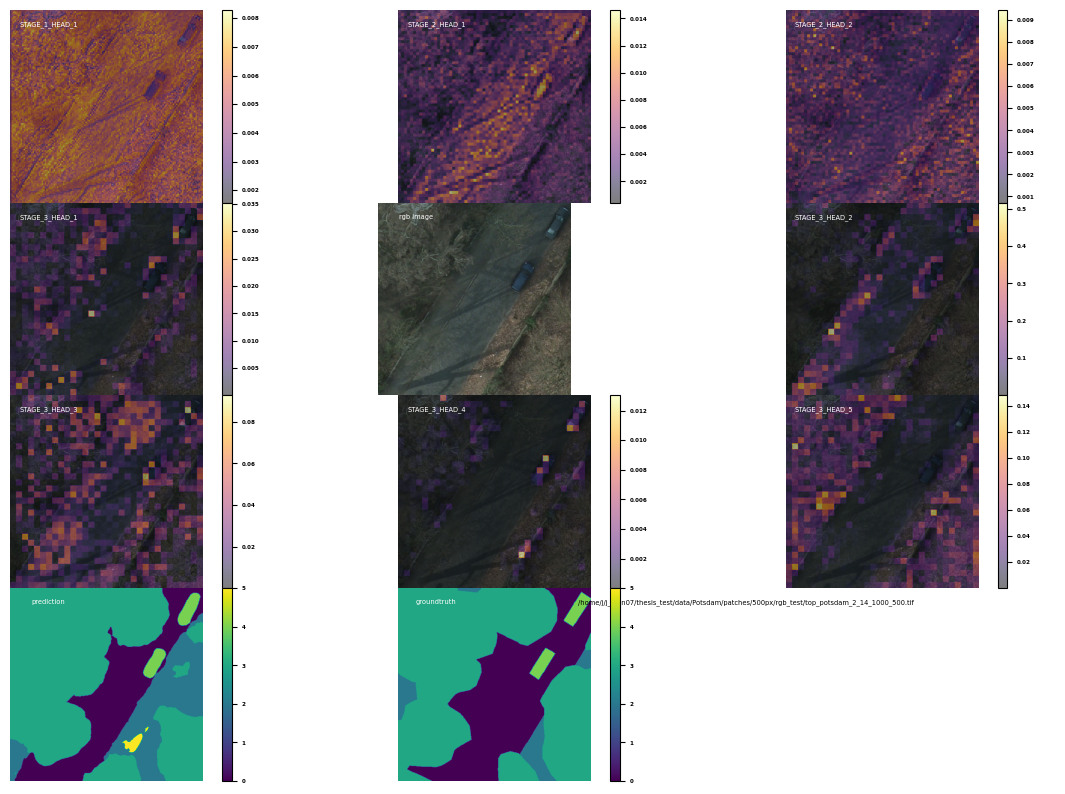

In [13]:
# range(1,2) does not show the plot
vis_attentions(range(21,22))

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


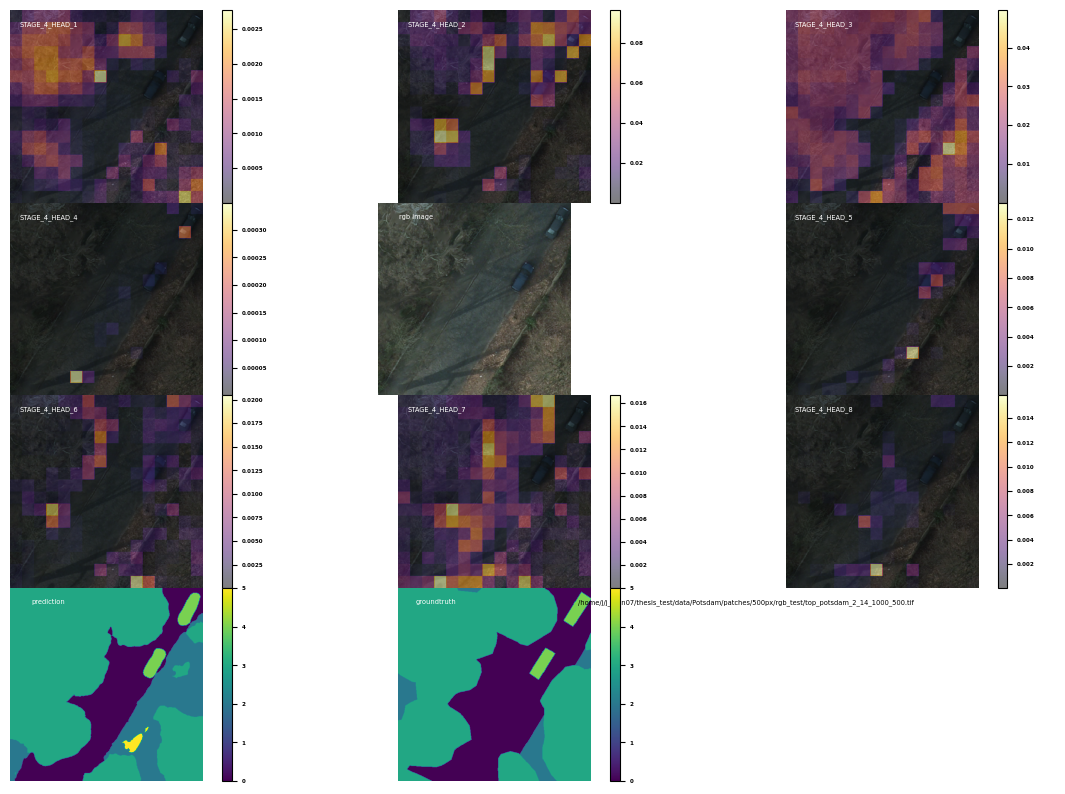

In [14]:
vis_attentions(range(21,22), stages = 'last')

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


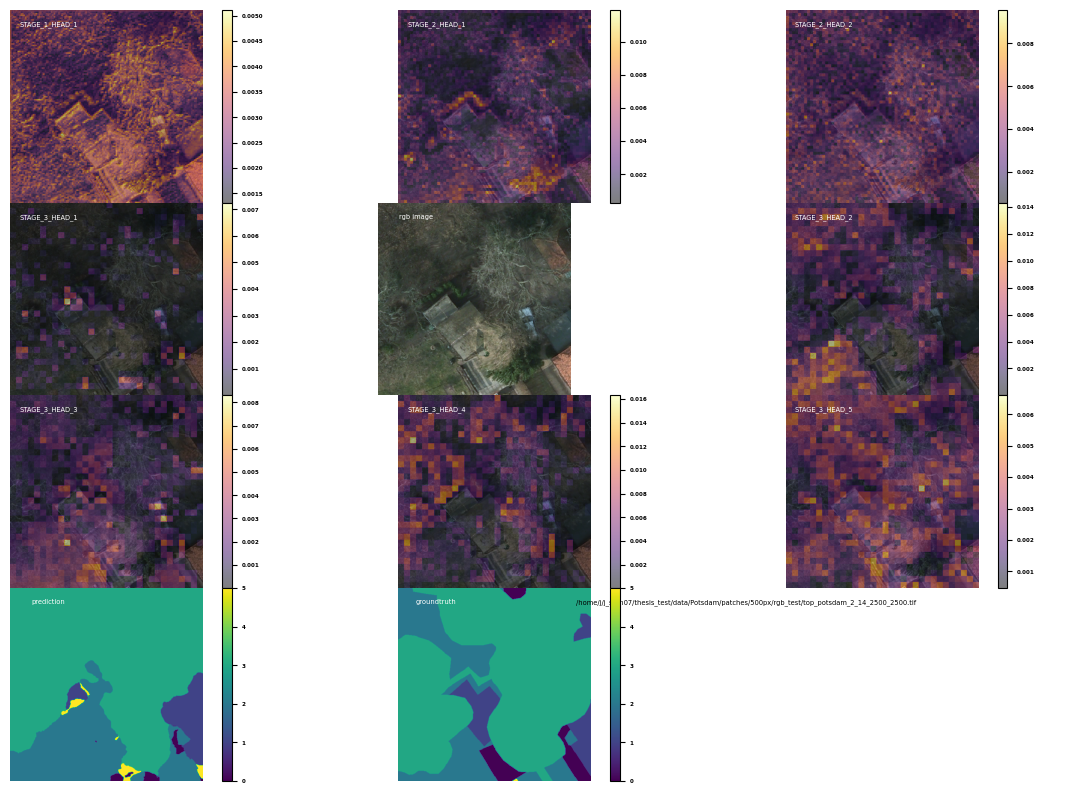

In [17]:
vis_attentions(range(52,53))

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


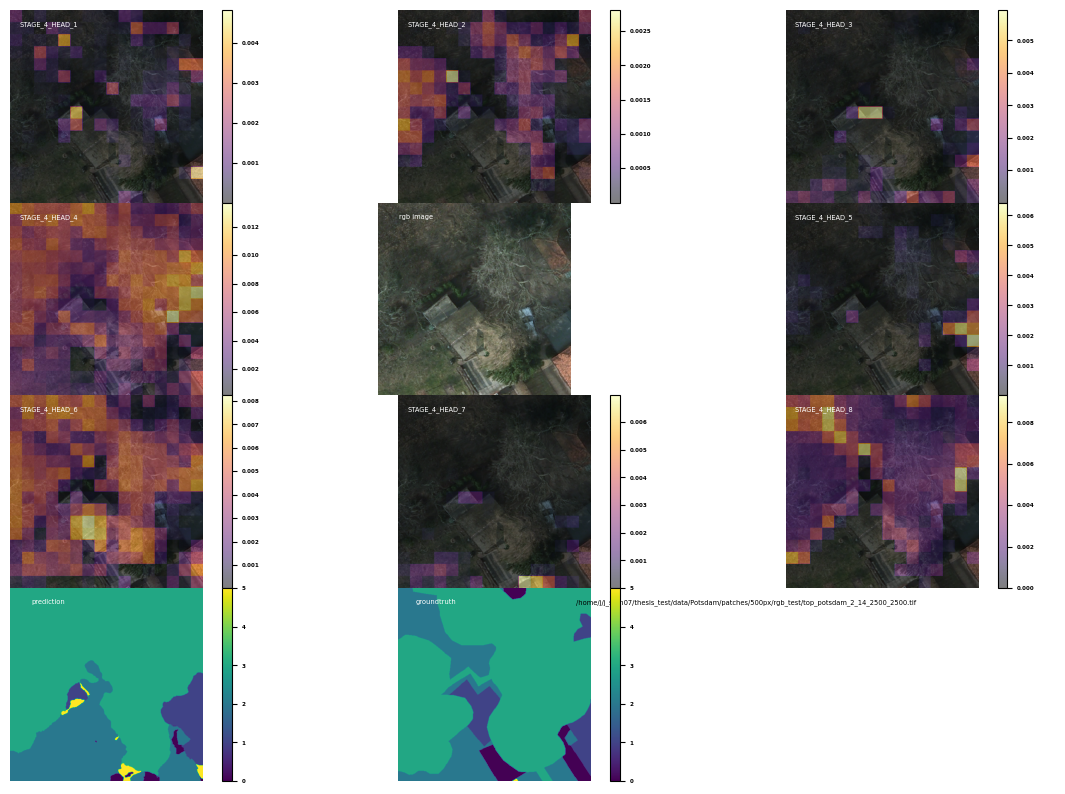

In [18]:
vis_attentions(range(52,53), stages = 'last')

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


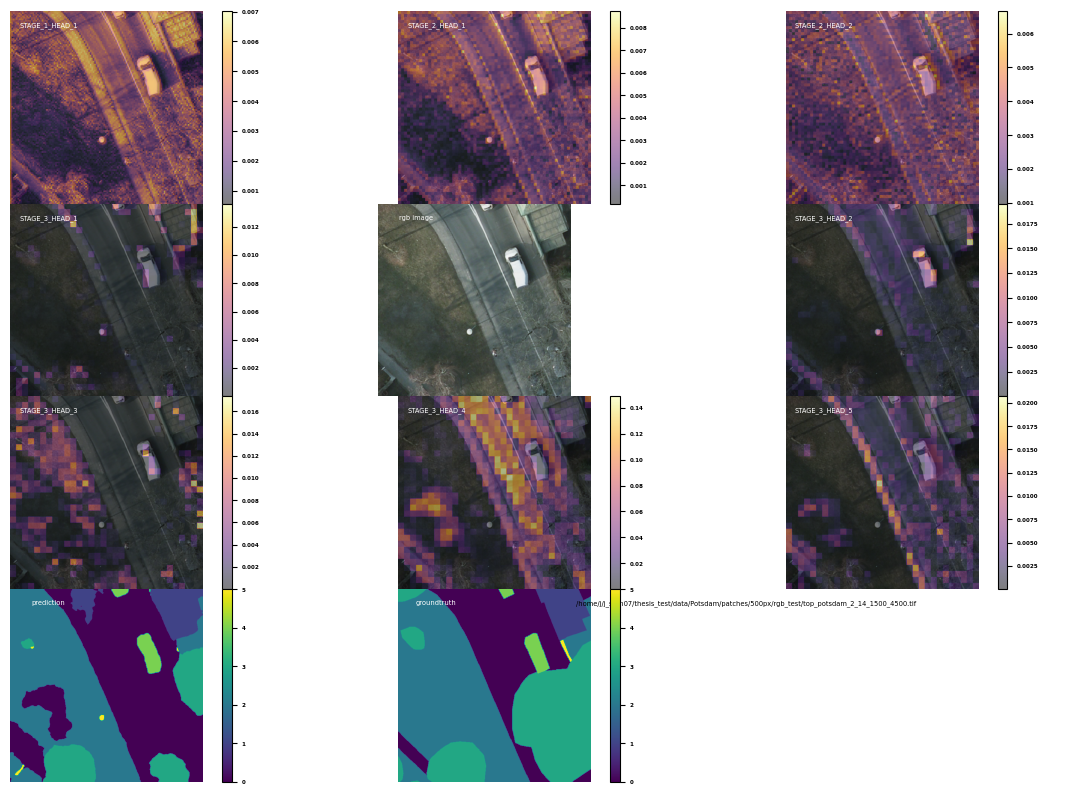

In [19]:
vis_attentions(range(32,33))

  0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([1, 1, 16384, 256])
1
torch.Size([1, 2, 4096, 256])
2
torch.Size([1, 5, 1024, 256])
3
torch.Size([1, 8, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


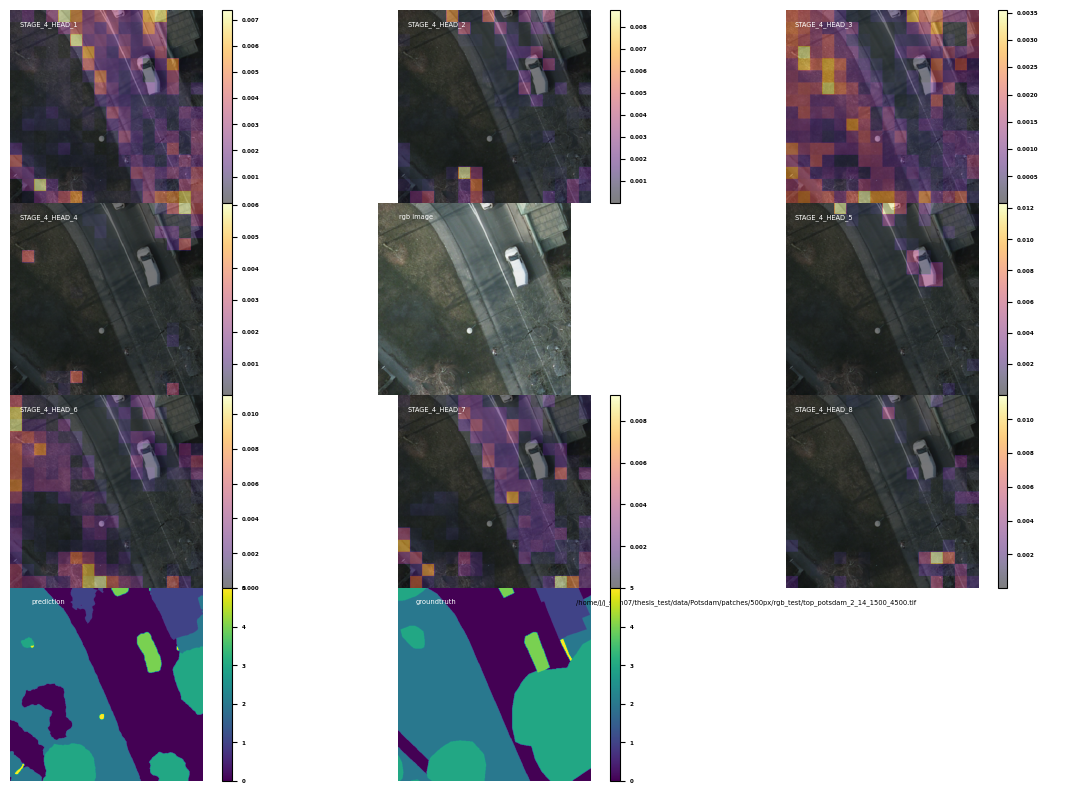

In [20]:
vis_attentions(range(32,33), stages = 'last')